In [1]:
#check for GPU please ignore
import tensorflow as tf 
from tensorflow.python.client import device_lib 

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5551512676501128486,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2148749322129998784
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7036698624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10183952910300953158
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3162496859607951116
 physical_device_desc: "device: XLA_GPU device"]

In [1]:
"""
Build RersNet50 
"""

'\nBuild RersNet50 \n'

In [1]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
#MIN-MAX Normalize 
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
InitSeed = 767 
tf.random.set_seed(InitSeed)
np.random.seed(InitSeed)

In [4]:
###1. Build a ResidualUnit Layer
def res_unit(x,filters,s):
    skip = x
    # 1 x 1, filters [64,128,256,512]
    x = keras.layers.Conv2D(filters, 1, s, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.25)(x)

    # 3 x 3, filters 
    x = keras.layers.Conv2D(filters, 3, 1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.25)(x)

    # 1 x 1, filters*4 
    x = keras.layers.Conv2D(filters*4, 1, 1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x,skip 
 

In [5]:
###2. entire network 
def skip_block(x,filters,s=2,change=False):
    stride = s 
    if change == False:
        x,skip = res_unit(x,filters,1)
        x = keras.layers.add([x, skip])
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        return x
    elif change == True:
        x,skip = res_unit(x,filters,stride)
        skip = keras.layers.Conv2D(filters*4,1,s, padding='same')(skip)
        skip = keras.layers.BatchNormalization()(skip)
        x = keras.layers.add([ x, skip])
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        return x

In [6]:
def model_res():
    x_input = keras.Input([32,32,3])
    
    #conV1
    x = keras.layers.Conv2D(64, 7, strides=2)(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)
    
    #conV2_x
    x = skip_block(x,64,s=2,change=True)
    for i in range(2):
        x = skip_block(x,64,1)
 
    #conV3_x
    x = skip_block(x,128,s=2,change=True)
    for i in range(3):
        x = skip_block(x,128,1)
    
    #conV4_x
    x = skip_block(x,256,s=2,change=True)
    for i in range(5):
        x = skip_block(x,256,1)
    
    
    #conv5_x
    x = skip_block(x,512,s=2,change=True)
    for i in range(2):
        x = skip_block(x,512,1)
    
    
    x = keras.layers.AveragePooling2D(2, padding='same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs=x_input, outputs=x)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(  patience=10, restore_best_weights=True), 
    tf.keras.callbacks.ModelCheckpoint( "best_model_hw8.h5",save_best_only=True), #save best model 
]

In [7]:
model = model_res()

In [8]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001,decay=1e-3)
              ,metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100,validation_split=0.1,verbose=1,callbacks=my_callbacks)

Epoch 1/100
1407/1407 [==============================] - 82s 58ms/step - loss: 3.0481 - accuracy: 0.1316 - val_loss: 2.2636 - val_accuracy: 0.1654
Epoch 2/100
1407/1407 [==============================] - 77s 55ms/step - loss: 2.3547 - accuracy: 0.1685 - val_loss: 2.4424 - val_accuracy: 0.1280
Epoch 3/100
1407/1407 [==============================] - 79s 56ms/step - loss: 2.2139 - accuracy: 0.1863 - val_loss: 2.1767 - val_accuracy: 0.1618
Epoch 4/100
1407/1407 [==============================] - 78s 56ms/step - loss: 2.1203 - accuracy: 0.1984 - val_loss: 2.0144 - val_accuracy: 0.2208
Epoch 5/100
1407/1407 [==============================] - 78s 55ms/step - loss: 2.0549 - accuracy: 0.2159 - val_loss: 1.9482 - val_accuracy: 0.2510
Epoch 6/100
1407/1407 [==============================] - 79s 56ms/step - loss: 2.0037 - accuracy: 0.2346 - val_loss: 1.9395 - val_accuracy: 0.2580
Epoch 7/100
1407/1407 [==============================] - 78s 55ms/step - loss: 1.9298 - accuracy: 0.2600 - val_loss: 1

1407/1407 [==============================] - 77s 55ms/step - loss: 1.4693 - accuracy: 0.4499 - val_loss: 1.4399 - val_accuracy: 0.4740
Epoch 57/100
1407/1407 [==============================] - 79s 56ms/step - loss: 1.4672 - accuracy: 0.4510 - val_loss: 1.4260 - val_accuracy: 0.4814
Epoch 58/100
1407/1407 [==============================] - 77s 55ms/step - loss: 1.4589 - accuracy: 0.4543 - val_loss: 1.4304 - val_accuracy: 0.4788
Epoch 59/100
1407/1407 [==============================] - 79s 56ms/step - loss: 1.4634 - accuracy: 0.4533 - val_loss: 1.3853 - val_accuracy: 0.4948
Epoch 60/100
1407/1407 [==============================] - 78s 55ms/step - loss: 1.4570 - accuracy: 0.4574 - val_loss: 1.4163 - val_accuracy: 0.4904
Epoch 61/100
1407/1407 [==============================] - 77s 54ms/step - loss: 1.4496 - accuracy: 0.4564 - val_loss: 1.4026 - val_accuracy: 0.4968
Epoch 62/100
1407/1407 [==============================] - 78s 56ms/step - loss: 1.4508 - accuracy: 0.4562 - val_loss: 1.5812 

In [9]:
test_score = model.evaluate(x_test,y_test)

313/313 [==============================] - 5s 15ms/step - loss: 1.3624 - accuracy: 0.5015


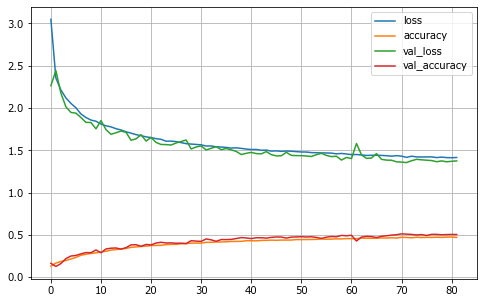

In [10]:
#plot leaning curve 
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.show()

In [32]:
###3. transfer learning
KerasModel = keras.applications.resnet50.ResNet50(weights='imagenet', input_tensor=keras.Input(shape=(32,32,3))) 

In [77]:
exchange = [] 
for i in range(320):
    if KerasModel.get_weights()[i].shape != model.get_weights()[i].shape:
        exchange.append(i)
exchange        

In [115]:
#same differences keep the original weights
tmp = KerasModel.get_weights()
target = KerasModel.get_weights()
target[78] =  model.get_weights()[78]
target[80] =  model.get_weights()[80]
target[156] = model.get_weights()[156]
target[158] = model.get_weights()[158]
target[270] = model.get_weights()[270]
target[272] = model.get_weights()[272]

In [116]:
model.set_weights(target) 